# Babson Analytics Hackathon | Supply Chain Analytics Case Study

## Problem Statement

In March 2020, there was a dramatic shift to consumer behaviour as a direct result of COVID-19.
Brick-and-Mortar stores were forced to close and/or operate under restrictions, customers were advised
to stay home, and there was nothing anyone could do to plan for it. As a result, more and more
customers began shopping online, for their homes, at Wayfair.

It is anticipated that the stay at home order advanced the conversion of furniture consumers to online by
more than 5 years, creating an unprecedented increase in demand to online channels. Our product
in-stock declined significantly which may have forced customers to shop at other stores to find the
products they need.

The Supply Chain Analytics team (you) has been tasked with building a recommendation on one or more
of the following topics:
- Supplier outreach strategy -- including Categories / Suppliers to target & prioritized SKU lists
- Opportunity size for decreasing customer in-stock gap
- Product substitution strategy
- Black Friday preparedness strategy
- Supply Chain Risks
- Any other recommendations for Supply Chain Leadership

We have provided you with datasets at the product class, Supplier, and SKU (i.e. product ID) level that
will help inform your strategy to tackle the Customer In-stock problem. (see Appendix for details on full
dataset).

Supply Chain Leadership is looking to you to create a 5-7 minute executive level presentation that
outlines your findings and recommendations.

In [1]:
from collections import Counter
from itertools import product
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('font', **{'size': 18})
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('ticks')

In [4]:
figure_path = '..\plots'
data_path = '..\data'

In [5]:
df_past = pd.read_csv(os.path.join(data_path, 'Customer In Stock Dataset Final.csv'), encoding='ISO-8859-1')
df_forward = pd.read_csv(os.path.join(data_path, 'Forward Coverage Dataset Final.csv'), encoding='ISO-8859-1')

df_past = df_past.rename(columns={
    'CustomerInstock_Denom':'Demand',
    'CustomerInstock_Num':'CoveredSales',
    'WholesaleCostNoRebates':'WholesaleCost'})

df_past['MissedDemand'] = df_past.WH_LostSales_OOS + df_past.DS_LostSales_OOS
df_past['InStockPerc'] = df_past.CoveredSales / df_past.Demand*100
df_past['L2marker'] = [np.nan]*len(df_past)
df_past['FCR_Type'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_oh'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_oo'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_if'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_l2'] = [np.nan]*len(df_past)
df_past['FromForward'] = [0]*len(df_past)

df_forward = df_forward.rename(columns={'Forecast':'Demand'})
df_forward['CoveredSales'] = df_forward[['qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']].sum(axis=1)
df_forward['MissedDemand'] = df_forward.Demand - df_forward.CoveredSales
df_forward['InStockPerc'] = df_forward.CoveredSales / df_forward.Demand*100
df_forward['L2marker'] = df_forward.FCR_Type.astype(str).str.lower().str.contains('l2').astype(int)
df_forward['FromForward'] = [1]*len(df_forward)

cols = ['FromForward', 'Date', 'SKU', 'suid', 'ItemMarketingCategory', 'ItemClass', 'Country', 'ItemShipClass', 'WholesaleCost', 'Demand', 'CoveredSales', 'MissedDemand', 'InStockPerc', 'L2marker', 'FCR_Type', 'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']
df = pd.concat([df_past[cols], df_forward[cols]], axis=0, ignore_index=True)

exclude_cols_past = [x for x in df_past.columns if x not in cols]
exclude_cols_forward = [x for x in df_forward.columns if x not in cols]
print(f'excluded past cols: {exclude_cols_past}')
print(f'excluded forward cols: {exclude_cols_forward}')

"""
excluded past cols: ['DateType', 'WH_CustomerInstock_Num', 'WH_CustomerInstock_Denom', 'Distributor_CustomerInstock_Num', 'Distributor_CustomerInstock_Denom', 'WH_LostSales_OOS', 'DS_LostSales_OOS']
excluded forward cols: ['DateType', 'FCR_Type', 'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']
"""

ids = df.WholesaleCost>0  # positive and not empty
ids &= df.Demand>0   # positive and not empty
df2 = df[ids].reset_index(drop=True)
#df2.to_csv(os.path.join(data_path, 'combined_dataset_0325.csv'), index=False)

#df2 = df2[(df2.FromForward==1)&(df2.Country=='United States')].reset_index(drop=True)
df2 = df2.drop(columns=['FromForward', 'Country', 'MissedDemand', 'InStockPerc'])
df2['NoL2marker'] = 1-df2.L2marker

df3 = df2.groupby(['Date', 'SKU', 'suid', 'ItemMarketingCategory', 'ItemClass', 'ItemShipClass']).agg({
    'L2marker':'sum',
    'NoL2marker':'sum',
    'WholesaleCost':'mean',
    'Demand':'max',
    'CoveredSales':'sum',
    'qty_fulfilled_oh':'sum',
    'qty_fulfilled_oo':'sum',
    'qty_fulfilled_if':'sum',
    'qty_fulfilled_l2':'sum'})
df3['MissedDemand'] = df3.Demand - df3.CoveredSales
df3['InStockPerc'] = df3.CoveredSales / df3.Demand*100
df3['DemandCount'] = df3.Demand / df3.WholesaleCost
df3['MissedCount'] = df3.MissedDemand/df3.WholesaleCost

df3 = df3[['L2marker', 'NoL2marker',
   'WholesaleCost', 'Demand', 'CoveredSales', 'MissedDemand', 'DemandCount', 'MissedCount', 'InStockPerc',
   'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if',
   'qty_fulfilled_l2']]
#df3.to_csv(os.path.join(data_path, 'combined_dataset_aggregated_0325.csv'))
df3 = df3.reset_index()

excluded past cols: ['DateType', 'WH_CustomerInstock_Num', 'WH_CustomerInstock_Denom', 'Distributor_CustomerInstock_Num', 'Distributor_CustomerInstock_Denom', 'WH_LostSales_OOS', 'DS_LostSales_OOS']
excluded forward cols: ['DateType']


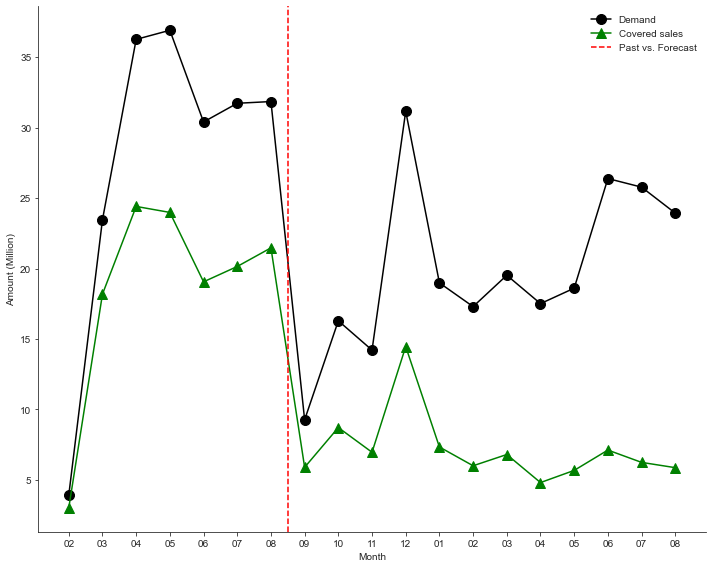

In [6]:
dates1 = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01']
dates2 = ['2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01','2021-06-01','2021-07-01','2021-08-01']
dates = dates1 + dates2

demands = []
covered = []
for date in dates:
    ids = df3.Date==date
    demands.append( df3.Demand[ids].sum()/1e6 )
    covered.append( df3.CoveredSales[ids].sum()/1e6 )

plt.close()
fig = plt.figure(figsize=(10,8))

tt = np.arange(len(dates))
ax = fig.add_subplot(111)
ax.plot(tt, demands, c='k', marker='o', ms=10, label='Demand')
ax.plot(tt, covered, c='g', marker='^', ms=10, label='Covered sales')
ax.axvline(6.5, c='r', ls='--', label='Past vs. Forecast')
ax.legend(frameon=False)
ax.set_xticks(tt)
#ax.set_xticklabels(dates, rotation=30, ha='right')
ax.set_xticklabels([x.split('-')[1] for x in dates])
ax.set_xlabel('Month')
ax.set_ylabel('Amount (Million)')
seaborn.despine()

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'demand_coveredsales_by_month.png'))